# Sea Level Rise Prediction with Pytorch

Climate change and its effect to sea condition is a hot topic on environmental condition in the world. While the sea level increase is not visible by our eyes, the impact can be felt by people who live near the sea. The impact of sea level rise get multiplicated especially if coupled with the occurence of land subsidence. While the land subsidence happens because of groundwater consumption, sea level rise happens because of temperature increase on our atmosphere. 

Recently the study of deep learning has become popular for time series forecasting especially Recurrent Neural Network (RNN) based model. With RNN based model like LSTM, we can predict sea level rise for some times in the future that cannot be predicted by conventional method like tidal harmonic analysis. The tidal harmonic analysis predict sea level based on tidal components and sea level rise happens because of climate change which is a non-tidal components. 

In this project I will work with a sea level dataset from a certain point in Charleston, South Carolina, USA and predicting its raise on a certain time with RNN method, LSTM. I pick the data from Charleston because the data has almost a century in term of length and it happen that the location also encounter land subsidence condition. You can read the condition [here](https://weather.com/news/climate/news/2020-09-23-charleston-flooding-sinking-sea-level-rise-climate-change).

## Import libraries and Dataset

In [29]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [30]:
df = pd.read_csv('data/daily Charleston 1921-2014.csv')

## Exploratory Data Analysis

In [31]:
def plot_dataset_trendline(df, title, label='value'):
    plt.figure(figsize=(15, 5))
    # plot dataset
    sns.lineplot(x=df.index, y=df.value, label=label)

    # plot trendline (have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="r", ls='-')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    print(f'Total Sea level rise: {round(p(len(df)) - p(0), 2)} mm')

In [32]:
# drop data in first line because its not technically data that we need
df.drop([0], inplace=True)
df.drop(columns=['depth', 'latitude', 'longitude', 'sensor_type_code'], inplace=True)

# change data types
df['time'] = pd.to_datetime(df['time'])
df['sea_surface_height_above_reference_level'] = pd.to_numeric(df['sea_surface_height_above_reference_level'])
df.dtypes

time                                        datetime64[ns, UTC]
sea_surface_height_above_reference_level                float64
dtype: object

### Check Missing Value

In [33]:
# check missing value and percentage
df_notna = pd.DataFrame(df.notna().sum()).rename(columns={0:'notna'}).reset_index()
df_isna = pd.DataFrame(df.isna().sum()).rename(columns={0:'isna'}).reset_index()
df_isna_perc = df_notna.merge(df_isna, on='index', how='inner')
df_isna_perc['isna_percentage'] = df_isna_perc['isna']/(df_isna_perc['isna']+df_isna_perc['notna'])*100
df_isna_perc.sort_values('isna_percentage',ascending=False).head()

,index,notna,isna,isna_percentage
1,sea_surface_height_above_reference_level,33529,804,2.34177
0,time,34333,0,0.00000


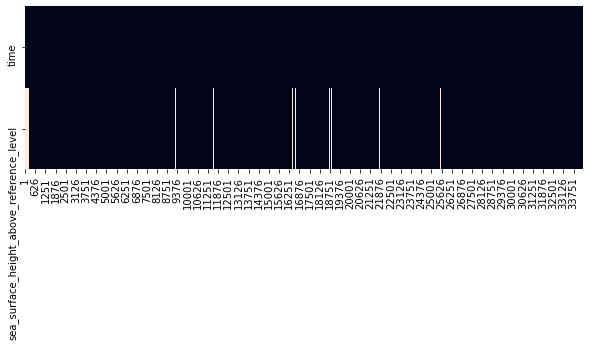

In [34]:
# Check missing value location in the data
plt.figure(figsize=(10, 3))
_ = sns.heatmap(df.isnull().T, cbar=False) #transpose the data so its easier to see

### Visualizing the data

Total Sea level rise: 297.52 mm


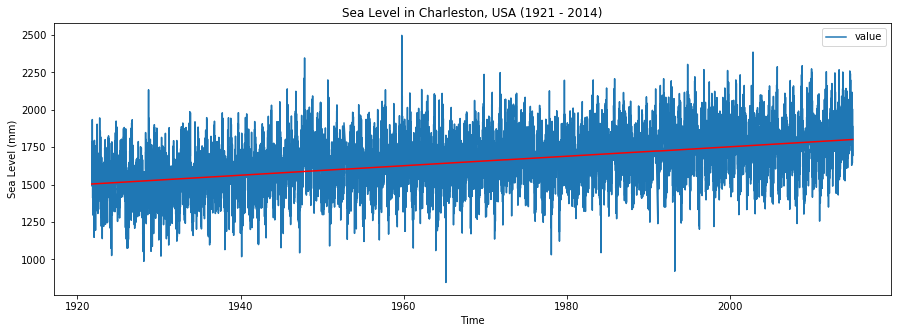

In [35]:
# make a new dataset for plotting (because we need to drop some missing values)
df_plot = df.dropna()
df_plot['year'] = df_plot['time'].dt.year
df_plot = df_plot.set_index(['time'])
df_plot = df_plot.rename(columns={'sea_surface_height_above_reference_level': 'value'})

# plot all of the dataset from 1921 - 2014
plot_dataset_trendline(df_plot, 'Sea Level in Charleston, USA (1921 - 2014)')

Total Sea level rise: 104.59 mm


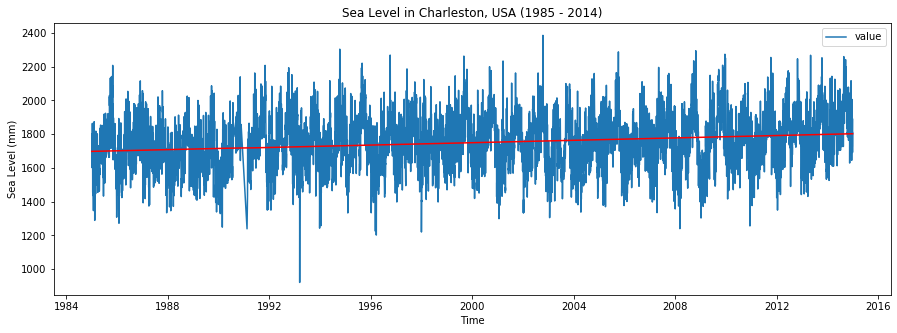

In [36]:
# plot latest 20 year of the dataset
plot_dataset_trendline(df_plot[df_plot['year'] > 1984], 'Sea Level in Charleston, USA (1985 - 2014)')

### Seasonal Decomposition

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
df_plot2 = df_plot.resample('M').mean()
df_plot2.reset_index(inplace= True)
df_plot2['time'] = df_plot2['time'].dt.to_period('M')
df_plot2 = df_plot2.set_index('time')
df_plot2.interpolate(inplace = True)
df_plot2.index = df_plot2.index.to_timestamp()
df_plot2.head()

,value,year
time,,
1921-10-01,1669.533333,1921.0
1921-11-01,1573.766667,1921.0
1921-12-01,1533.225806,1921.0
1922-01-01,1421.516129,1922.0
1922-02-01,1478.607143,1922.0


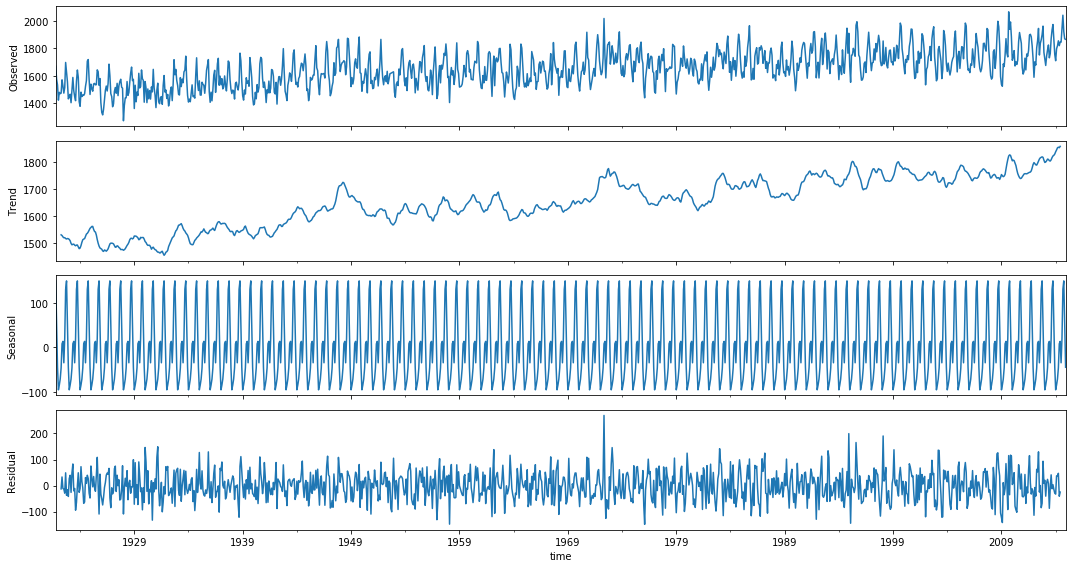

In [63]:
plt.rc("figure", figsize=(15,8))
result = seasonal_decompose(df_plot2['value'], model= 'additive')
result.plot()
plt.show()

As we can see on the picture above, our data has a seasonal composition which forms a sinusoidal wave pattern. The nature of tidal phenomenon (sea level) which happen because of gravitational force of moon, sun, and other sky objects that have huge mass. The gravitational effect of those objects makes a sinusoidal patern like one on seasonal composition above.This seasonal pattern usually have another pattern that moves up and down in a period of 18.6 years. In theory, this condition happened because of astronomical cycle condition of moon and sun position that reached their nearest position to earth. You can read more about the topic [here](https://noc.ac.uk/news/highest-tides-186-years). 

The trend pattern should have been following this 18.6 years cycle patter but on the trend showed above, it keep increasing. This trend happened because of the increase of our atmosphere temperature or people said as climate change.

## Choosing the data
From the inspection that I have done, there are some sequential missing values in 1952, 1972, and 1991 which is quite a number for each year. Because our data has seasonal composition because of the sky objects phenomena, it makes the missing data in the middle of dataset can be easily interpolated, but when the data missing is too much the pattern changed and makes some value invalid. Other than that, the model don't calculate physical phenomenon above and only predict based on the pattern made by the data. Because of this reason I choose to drop the data before 1995.

In [40]:
# subsetting data from 1995 until 2014
df['year'] = df['time'].dt.year
df_m95 = df[df['year'] > 1994]

df_m95 = df_m95.reset_index()
df_m95.drop(columns=['index', 'year'], inplace=True)

# make a copy as a safety measure for later process
df_try = df_m95.copy()
df_try.tail(2)

,time,sea_surface_height_above_reference_level
7303,2014-12-30 12:00:00+00:00,1789.0
7304,2014-12-31 12:00:00+00:00,1888.0


Total Sea level rise: 74.2 mm


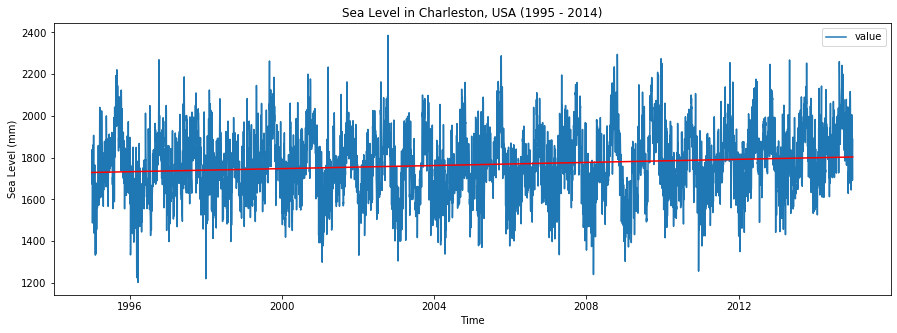

In [41]:
df_try = df_try.set_index(['time'])
df_try = df_try.rename(columns={'sea_surface_height_above_reference_level': 'value'})

# plot the dataset that we're gonna use
plot_dataset_trendline(df_try, title='Sea Level in Charleston, USA (1995 - 2014)')

## Generating date/time predictors

So the dataset is ready, the next step is to generate feature columns to transform our univariate dataset into a multivariate dataset. We are going to make new features using our datetime features.

In [42]:
# generate day, month, and week of year feature
df_features = (df_try
                .assign(day = df_try.index.day)
                .assign(month = df_try.index.month)
                .assign(week_of_year = df_try.index.week))

In [43]:
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
    
    return pd.concat([df, dummies], axis=1).drop(columns=cols)

# one-hot encoding for categorical value from datetime feature
df_features = onehot_encode_pd(df_features, ['day', 'month', 'week_of_year'])
df_features.tail(3)

,value,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
time,,,,,,,,,,,,,,,,,,,,,
2014-12-29 12:00:00+00:00,1692.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-30 12:00:00+00:00,1789.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-31 12:00:00+00:00,1888.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the data into test, validation, and train sets
We need to separate our 10 years data as a train, validation, and test dataset for next processing. Here we will use train_test_spplit function from sklearn to separate the data. There is a parameter in this function that will be different from when we use it on normal machine learning problems, which is shuffle. This parameter has a True value as a default and it makes the function takes random rows from our dataframe when separates the data. If we set this parameter as False, the function is going to separate our dataframe sequentially. This is going to be needed when we have a time series forecasting problem.

In [44]:
from sklearn.model_selection import train_test_split

# function for splitting target dan predictor variable
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

# function for splitting data to train, test, and validation data
def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, 'value', 0.2)

## Applying scale transformation
Scaling is useful because it speeds up the learning by making the model easier to update weight. While the features doesn't need scaling, we use the scaler to make it's shape become numpy array so we have the same input when we processing them to be DataLoader later.

In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

# function to pick scaler 
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [46]:
scaler = get_scaler('minmax')

# fit and apply scaler to predictor variable
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

# fit and apply scaler to target variable
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

## Loading the data into DataLoaders
RNN architecture makes us need to splits our data as mini-batch and the DataLoader class by Pytorch does that for us. But before we use the DataLoader, we have to make our data as Dataset (not technically a dataset but a name of object on Pytorch) which is a dataset object to load data from. Since we make our data shape as tensors we use TensorDataset (dataset class wrapping tensors) to make that Pytorch Dataset. Also because sklearn scalers have Numpy arrays as output, we need to convert the data into Torch tensors before we load them to TensorDatasets.

In [47]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# convert data shape to tensor (multi-dimensional matrix containing elements of a single data type)
train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

# wrapping the tensors above as Dataset
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

# convert data to Pytorch DataLoader (collating data samples into batches)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

## Long Short-Term Memory (LSTM) Architecture

Traditional neural networks start from scratch every time they are given a task. RNN addresses this shortcoming by looping the information from one step of the network to the next, allowing information to persist within the network. This makes RNN can solve various problems involving sequential data or in this case time-series forecasting. <br>
Simple RNN can connect previous information to the current one, where the temporal gap between the relevant past information and the current one is small. As that gap grows, RNN become less capable of learning the long-term dependencies, also known as the vanishing gradient problem. This is why we are going to use LSTM or Long Short-Term Memory. <br>
LSTM is able to learn long-term dependencies. The difference with normal RNN is that LSTM has the cell state in addition of the hidden state which carries relevant information from earlier steps to later steps. The new information are going to be removed from this cell state via input and forget gates. For more thorough information about LSTM, you can read [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In [48]:
import torch.nn as nn

class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       --Attributes--
           hidden_dim: int 
               The number of nodes in each layer
           layer_dim: int
               The number of layers in the network
           lstm: nn.LSTM
               The LSTM model constructed with the input parameters.
           fc: nn.Linear
               The fully connected layer to convert the final state of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        --Arguments--
            input_dim: int
                The number of nodes in the input layer
            hidden_dim: int
                The number of nodes in each layer
            layer_dim: int
                The number of layers in the network
            output_dim: int
                The number of nodes in the output layer
            dropout_prob: float
                The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        --Arguments--
            x: torch.Tensor 
                The input tensor of the shape (batch size, sequence length, input_dim)

        --Returns--
            out: torch.Tensor 
                The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

## Making predictions

Before we get into training model and making predictions, we will make a framework. In this case we will make a helper class that hold training, validation and evaluation methods that we will use later. 

### Helper Class for training

Training data using neural networks is a repetitive process, looping between forward and back-propagation. To help us with that we will make a helper class named Optimization which help us combine the looping steps. This helper class contain one training step and then training loop that will be called each epoch. The weight of network will be updated on each training step. This process is important to minimize the loss function. Each epoch has two stages that use different dataset, training and validation dataset. The loss in train() function get updated on each epoch, while the loss in eval() function only there to compare the performance of our training model with validation one on the plot loss function.

In [49]:
class Optimization:
    """
    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    --Attributes--
        model: 
            Model class created for the type of RNN
        loss_fn: torch.nn.modules.Loss
            Loss function to calculate the losses
        optimizer: torch.optim.Optimizer 
            Optimizer function to optimize the loss function
        train_losses: list[float]
            The loss values from the training
        val_losses: list[float]
            The loss values from the validation
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """
        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        --Arguments--
            x: torch.Tensor
                Tensor for features to train one step
            y: torch.Tensor
                Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """
        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. Finally, it saves the model in a designated file path.

        --Arguments--
            train_loader: torch.utils.data.DataLoader
                DataLoader that stores training data
            val_loader: torch.utils.data.DataLoader
                DataLoader that stores validation data
            batch_size: int
                Batch size for mini-batch training
            n_epochs: int 
                Number of epochs, i.e., train steps, to train
            n_features: int
                Number of feature columns

        """
        model_path = f'model/model_{datetime.now().strftime("%Y-%m-%d^%H-%M")}'
        
        for epoch in range(1, n_epochs + 1):
            # mini-batch training iteration of training datasets
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                # update training loss value
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                # mini-batch training iteration of validation datasets
                batch_val_losses = []
                validation = []
                validation_values = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    #
                    validation.append(yhat.to(device).detach().numpy())
                    validation_values.append(y_val.to(device).detach().numpy())
                # update validation loss value    
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
            
            # print loss value per epoch period
            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
        return validation, validation_values

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model
            values: list[float]
                The actual values in the test set.

        """
        # mini-batch testing to evaluate data from test dataset
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def predict(self, future_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the predicting future dataset, batch size for mini-batch testing,
        and number of features as inputs. 

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model

        """
        # mini-batch testing to predict data from future dataset
        with torch.no_grad():
            predictions = []
            for x_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())

        return predictions
    
    def plot_losses(self):
        """
        The method plots the calculated loss values for training and validation
        """
        plt.figure(figsize=[8, 5])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

### Set Configurations of Parameters
The configuration belows are parameter values that we are going to use on our model. Our neuron showed by hidden_dim parameters. Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network, which reduce overfitting and improving model performance.

In [50]:
# LSTM config
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 4
batch_size = batch_size
dropout = 0.1
# training and evaluate config
n_epochs = 30
# weight optimization config
learning_rate = 1e-3
weight_decay = 1e-6

# bundle config in dictionary
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

### Training the model
The model we are going to use is LSTM with AdamW as optimizer that you can explore more [here](https://pytorch.org/docs/stable/optim.html#algorithms). The training process starts when we call our helper class it does one training process and it continues the training loop with train function.

[1/30] Training loss: 0.0659	 Validation loss: 0.0193
[2/30] Training loss: 0.0163	 Validation loss: 0.0161
[3/30] Training loss: 0.0146	 Validation loss: 0.0149
[4/30] Training loss: 0.0144	 Validation loss: 0.0143
[5/30] Training loss: 0.0141	 Validation loss: 0.0143
[6/30] Training loss: 0.0140	 Validation loss: 0.0139
[7/30] Training loss: 0.0138	 Validation loss: 0.0138
[8/30] Training loss: 0.0136	 Validation loss: 0.0137
[9/30] Training loss: 0.0135	 Validation loss: 0.0138
[10/30] Training loss: 0.0135	 Validation loss: 0.0137
[20/30] Training loss: 0.0129	 Validation loss: 0.0134
[30/30] Training loss: 0.0127	 Validation loss: 0.0134


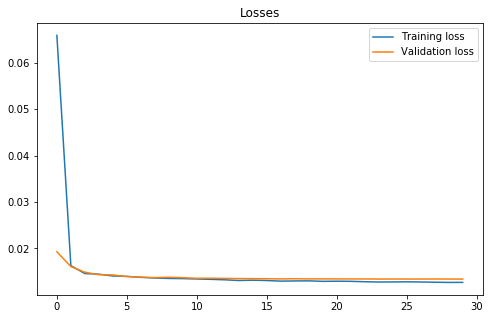

In [51]:
import torch.optim as optim

model = LSTMModel(**model_params)

# set criterion to calculate loss gradient
loss_fn = nn.MSELoss(reduction="mean")
# set model optimizer (process of adjusting model parameters to reduce model error in each training step)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# training model
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
validation, validation_values = opt.train(
    train_loader, 
    val_loader, 
    batch_size=batch_size, 
    n_epochs=n_epochs, 
    n_features=input_dim,
)
opt.plot_losses()

# evaluate model based on model from training dataset
predictions, values = opt.evaluate(
    test_loader,
    batch_size=batch_size,
    n_features=input_dim
)

### Formatting the results

Our validation and evaluation mini-batch method makes our result in batches so we need to reshape the multi-dimensional tensors to one-dimensional vector or flatten them. But before that, because we use scaling to standardized the inputs, we have to revert the result to normal condition. As the shape back to normal dataframe, we can calculate error metrics and plot them.

In [52]:
# inverse the scale from model result
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

# change format of multi-dimensional tensors to one-dimensional vectors (flatten)
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [53]:
df_val = format_predictions(validation, validation_values, X_val, scaler)
df_result = format_predictions(predictions, values, X_test, scaler)
df_result.head()

,value,prediction
time,,
2011-01-01 12:00:00+00:00,1589.000000,1658.873657
2011-01-02 12:00:00+00:00,1478.000000,1658.873657
2011-01-03 12:00:00+00:00,1501.000122,1641.912354
2011-01-04 12:00:00+00:00,1632.000000,1641.912354
2011-01-05 12:00:00+00:00,1608.000122,1641.912354


### Calculating error metrics
Before visualizing the prediction of our test data, we are going to inspect our prediction error. The metrics that we are going to use are MAE, RMSE, and MAPE.

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : np.sqrt(mean_squared_error(df.value, df.prediction)),
                      'mape' : mean_absolute_percentage_error(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("MAPE Score:                ", result_metrics["mape"])
    
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        106.4863
Root Mean Squared Error:    137.01341
MAPE Score:                 0.057829093


### Visualizing the predictions
Then we compare our prediction with our observation values. There will be three plot that showing the comparison of our test data only, the plot that showing all of our data, including validation and test data prediction, and the different in trendline on our test data plot.

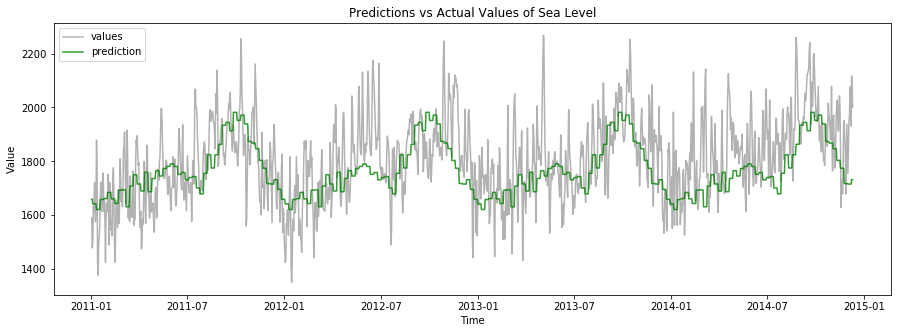

In [56]:
def plot_predictions(df_result):
    plt.figure(figsize=(15,5))
    value = sns.lineplot(x = df_result.index, y=df_result.value, color='k', alpha = 0.3, label = 'values')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Predictions vs Actual Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_predictions(df_result)

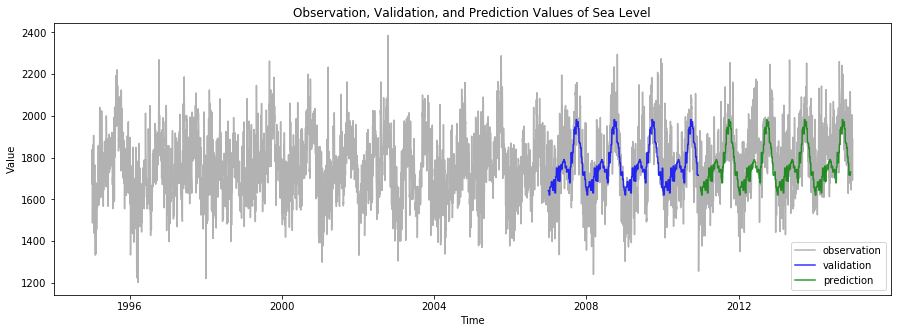

In [57]:
def plot_all(df_result, df_train, df_val):
    plt.figure(figsize=(15,5))
    observation = sns.lineplot(x = df_train.index, y=df_train.value, color='k', alpha = 0.3, label = 'observation')
    validation = sns.lineplot(x = df_val.index, y=df_val.prediction, color='b', alpha = 0.8, label = 'validation')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Observation, Validation, and Prediction Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_all(df_result, df_features, df_val)

Sea level rise (values) from 2011-2014: 170.51 mm
Sea level rise (prediction) from 2011-2014: 54.54 mm


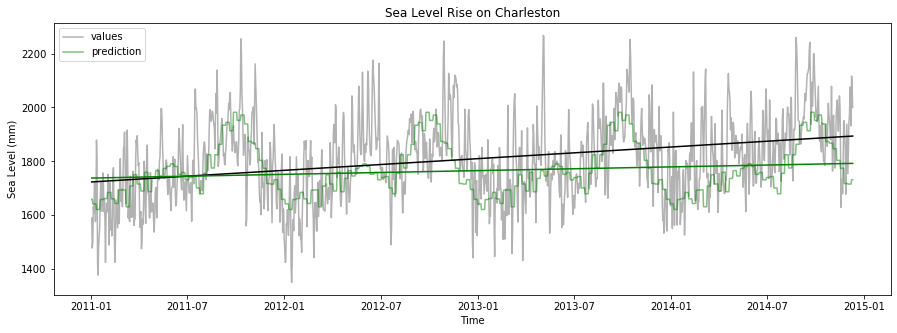

In [58]:
def plot_dataset_trendline_after_model(df, title):
    plt.figure(figsize=(15, 5))
    # plot dataset
    sns.lineplot(x=df.index, y=df.value, color = 'k', alpha = 0.3, label='values')
    sns.lineplot(x=df.index, y=df.prediction, color='g', alpha= 0.5, label='prediction')

    # plot trendline of observation value
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="k", ls='-')
    print(f'Sea level rise (values) from 2011-2014: {round(p(len(df)) - p(0), 2)} mm')
    
    # plot trendline of prediction (have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.prediction, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="g", ls='-')
    print(f'Sea level rise (prediction) from 2011-2014: {round(p(len(df)) - p(0), 2)} mm')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    
plot_dataset_trendline_after_model(df_result, 'Sea Level Rise on Charleston')

## Predict Future Sea Level
After we have the model, we are going to predict with the data from 2015 - 2017. We will need a new dataframe containing time column only and use the same process when we prepare our data before.

In [59]:
from datetime import date

sdate = date(2015,1,1)   # define start date
edate = date(2017,12,31)   # define end date

# make a dataframe with range of sdate and edate
df_future = pd.DataFrame(pd.date_range(sdate, edate, freq='d'))
df_future.columns = ['time']
df_future['value'] = 0 # it's just here because the function need it as an input
df_future.set_index('time', inplace=True)

# make features with datetime object
df_future = (df_future
             .assign(day = df_future.index.day)
             .assign(month = df_future.index.month)
             .assign(week_of_year = df_future.index.week))

# one hot encoding the features
df_future = onehot_encode_pd(df_future, ['day', 'month', 'week_of_year'])

In [60]:
# split the data that we going to predict
X_fut, y_fut = feature_label_split(df_future, 'value')

#scaling
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_fut_arr = scaler.transform(X_fut)
y_train_arr = scaler.fit_transform(y_train)
y_fut_arr = scaler.transform(y_fut)

# convert to tensor
X_fut_tens = torch.Tensor(X_fut_arr)
y_fut_tens = torch.Tensor(y_fut_arr)

# convert to Dataset object (pytorch)
future = TensorDataset(X_fut_tens, y_fut_tens)
future_loader = DataLoader(future, batch_size=batch_size, shuffle=False, drop_last=True)

In [61]:
# predict using evaluate function
fut_predictions, fut_values = opt.evaluate(
    future_loader,
    batch_size=batch_size,
    n_features=input_dim
)

# format the prediction result
df_future_predict = format_predictions(fut_predictions, fut_values, X_fut, scaler)

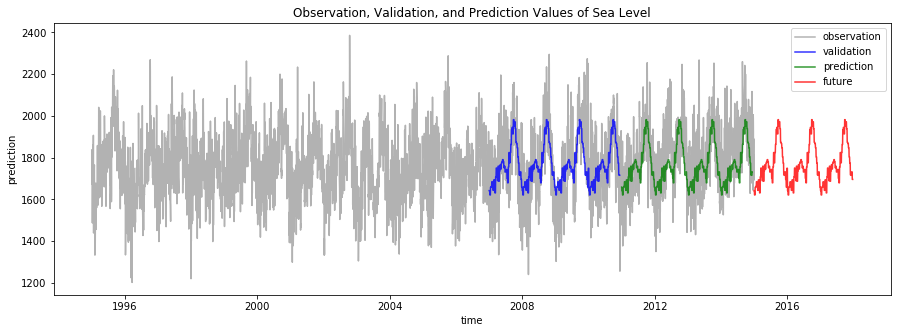

In [62]:
def plot_future(df_result, df_train, df_val, df_future):
    plot_all(df_result, df_train, df_val)
    future = sns.lineplot(x = df_future.index, y=df_future.prediction, color='r', alpha = 0.8, label = 'future')
    
plot_future(df_result, df_features, df_val, df_future_predict)

## Conclusions and Point to Improve

From the result above we can see that the model cannot get the daily pattern of sea level and only catch its seasonal pattern. Also the model have not catch the increase in trend of sea level rise that we can see on seasonal decomposition plot. From this we can try to improve the model by resampling the data to weekly, adding more feature from the datetime objects that we have not used. We can also breakdown our seasonal component because it seems we have dataset with multiseasonal condition here, then we try another approach to process our data.

While the model have not generated a result on predicting increase in trendline, the observation data shows the condition of our world explicitly. The climate change is real and increase in sea level rise is happening even right now. The value might be small if we seen it in a short-term but from almost a century of data in Charleston it shows about 30 cm of rise. 

# References
1. Kuguoglu, Kaan (2021). Building RNN, LSTM, and GRU for time series using PyTorch. Retrieved from: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
2. Olah, Chris (2015). Understanding LSTM Networks. Retrieved from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
3. Masri, Fikhri, et. al. Forecasting of Sea Level Time Series using Deep Learning RNN, LSTM, and BiLSTM, Case Study in Jakarta Bay, Indonesia. e-Proceeding of Engineering : Vol.7, No.2 Agustus 2020, Page 8544-8551